# iForest

In [125]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [126]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [127]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [128]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## Allianz

**Dataset source**: private dataset from allianz benelux

In [129]:
dataset_id = 'allianz'

data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(42358, 36)

In [130]:
excluded_cols = []

### iForest

## Parameters

In [192]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)

df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))

df['shap_ad_q2'] = df['shap_stab_ad'].apply(lambda x: np.percentile(x, 50))

df['shap_mean'] = df['shap_stab'].apply(lambda x: np.mean(x))


#df['shap_stab'] = df['shap_q2']
#df['shap_inestab'] = 1- df['shap_stab']


var = ['n_estimators', 'max_feats', 'n_feats', 'model_stab', 'shap_stab', 'shap_q2', 'shap_mean']
df = df[var]

In [193]:
#df = df[(df.n_estimators<100) & (df.n_feats>=12) & (df.max_feats>=12)]

## Optimization

In [194]:
df.sort_values('shap_mean', ascending=False).head(5)

,n_estimators,max_feats,n_feats,model_stab,shap_stab,shap_q2,shap_mean
448,100,2,3,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,1.0
885,300,2,3,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,1.0
609,175,2,2,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,1.0
608,175,2,2,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,1.0
607,175,2,2,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,1.0


In [178]:
df.shape

(935, 7)

In [179]:
sorted_df = opt_value(df, lambda_=0.7, var1='model_stab', var2='shap_mean')

opt_x = int(sorted_df.iloc[0:1,:].n_estimators)
opt_y = int(sorted_df.iloc[0:1,:].n_feats)

sorted_df

,n_estimators,max_feats,n_feats,model_stab,shap_stab,shap_q2,shap_mean,opt_value
551,150,2,2,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000,1.000000
830,275,2,3,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000,1.000000
828,275,2,2,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000,1.000000
330,50,2,2,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000,1.000000
165,15,2,2,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
41,1,9,23,0.770319,"[0.8781933459384267, 0.9467651246882192, 0.828...",0.814631,0.831327,0.788621
54,1,36,36,0.760178,"[0.7893425667260277, 0.8631902862652577, 0.778...",0.791154,0.789180,0.768878
53,1,28,36,0.738072,"[0.8134758389521243, 0.8151476745400335, 0.824...",0.797149,0.797781,0.755984
43,1,18,23,0.669408,"[0.932975061737116, 0.841860831296414, 0.86706...",0.875016,0.875339,0.731187


## Visualization of the results

In [160]:
# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_n_trees = df.loc[idx].reset_index(drop=True)

# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'max_feats'])['n_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_max_feat = df.loc[idx].reset_index(drop=True)

In [165]:
df = df_n_trees.copy()
df.head()

,n_estimators,max_feats,n_feats,model_stab,shap_stab,shap_inestab,shap_q2,shap_mean,opt_value
0,1,2,2,1.000000,0.200198,0.799802,0.200198,0.429792,0.828937
1,1,3,3,1.000000,0.992699,0.007301,0.992699,0.991050,0.997315
2,1,5,5,0.999996,0.967325,0.032675,0.967325,0.701941,0.910580
3,1,7,7,0.996688,0.889609,0.110391,0.889609,0.780525,0.931839
4,1,9,9,0.998166,0.943950,0.056050,0.943950,0.945787,0.982452


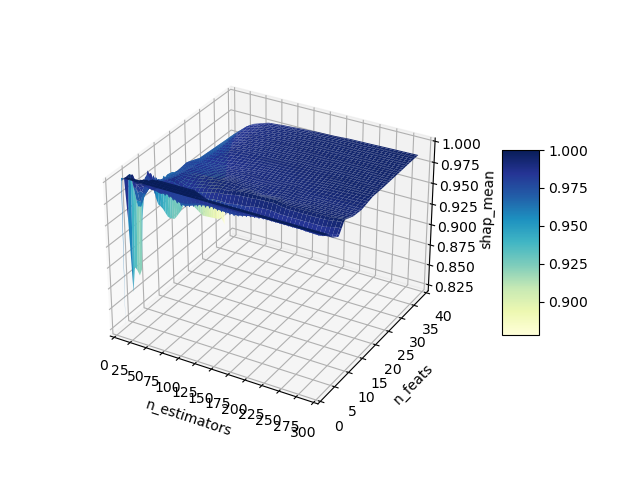

In [166]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'shap_mean', cmap='YlGnBu', x_step=25, y_step=5)

In [170]:
df_test = df[(df.n_estimators<100) & (df.n_feats>12)]
df_test.sort_values('n_estimators')

,n_estimators,max_feats,n_feats,model_stab,shap_stab,shap_inestab,shap_q2,shap_mean,opt_value
6,1,15,15,0.950542,0.911419,0.088581,0.911419,0.904460,0.936717
7,1,19,19,0.904587,0.876711,0.123289,0.876711,0.867451,0.893446
8,1,23,23,0.925978,0.891625,0.108375,0.891625,0.887708,0.914497
9,1,34,34,0.933390,0.812544,0.187456,0.812544,0.812736,0.897193
10,1,36,36,0.760178,0.791154,0.208846,0.791154,0.789180,0.768878
21,5,36,36,0.858552,0.905149,0.094851,0.905149,0.900839,0.871238
19,5,23,23,0.891575,0.951700,0.048300,0.951700,0.943993,0.907300
20,5,34,34,0.853527,0.908088,0.091912,0.908088,0.903526,0.868527
17,5,15,15,0.964319,0.963425,0.036575,0.963425,0.951417,0.960449
18,5,19,19,0.878993,0.946969,0.053031,0.946969,0.936803,0.896336


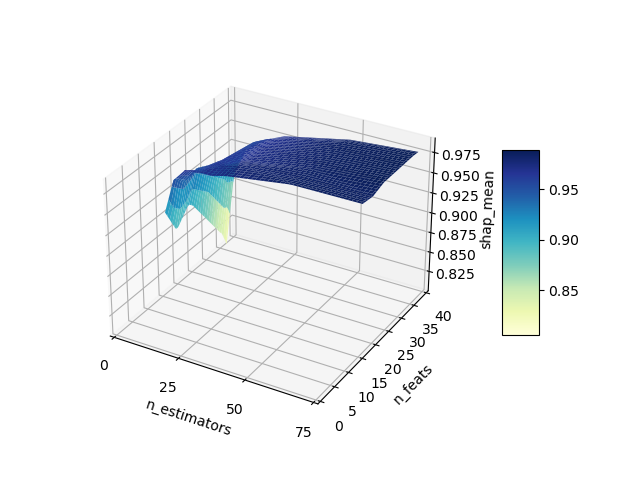

In [169]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df_test, 'n_estimators', 'n_feats', 'shap_mean', cmap='YlGnBu', x_step=25, y_step=5)

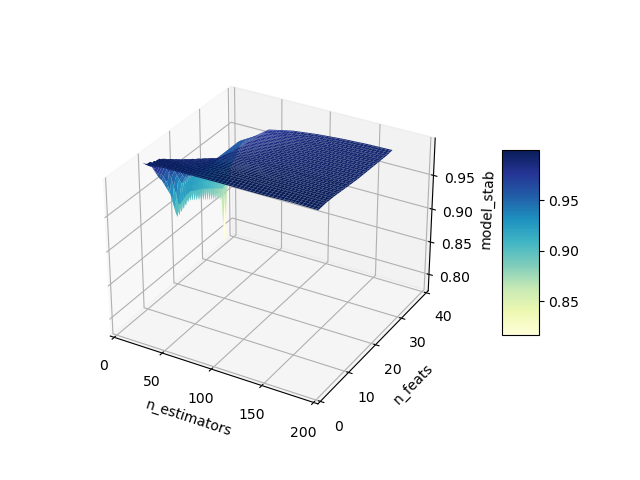

In [123]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'model_stab', cmap='YlGnBu', x_step=50, y_step=10)

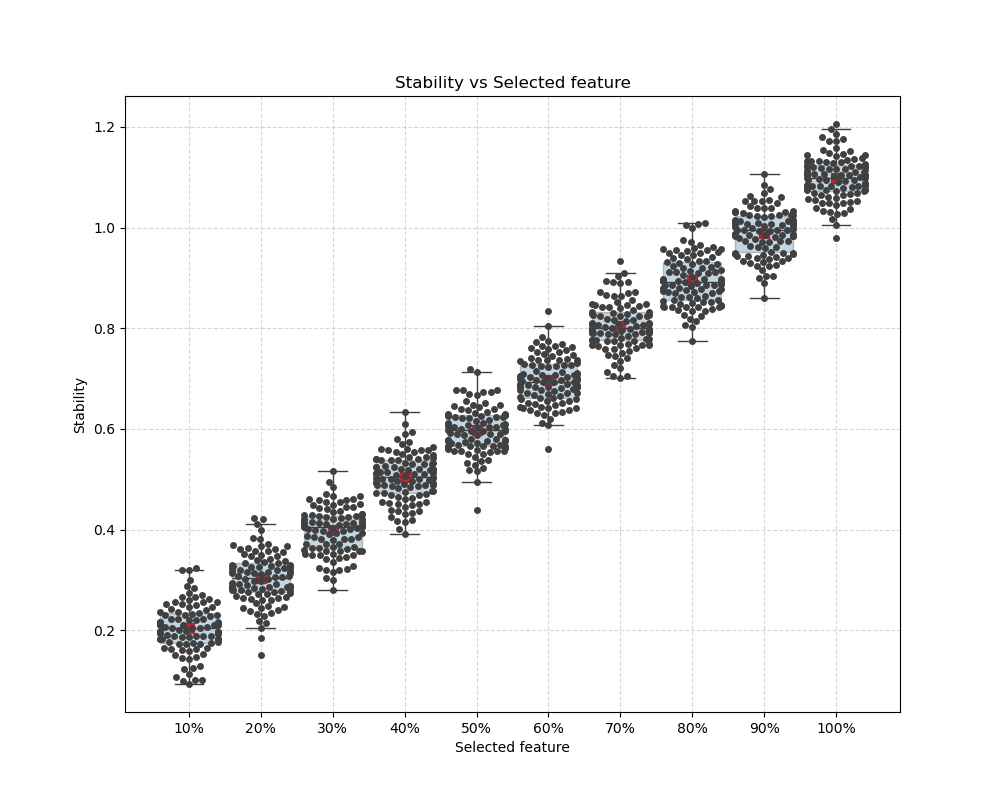

In [185]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

variable1 = 'Stability'
variable2 = 'Selected feature'
# Generating sample data similar to the user's uploaded image
np.random.seed(10)
data = pd.DataFrame({
    f'{variable1}': np.concatenate([
        np.random.normal(0.2, 0.05, 100), 
        np.random.normal(0.3, 0.05, 100), 
        np.random.normal(0.4, 0.05, 100), 
        np.random.normal(0.5, 0.05, 100), 
        np.random.normal(0.6, 0.05, 100),
        np.random.normal(0.7, 0.05, 100),
        np.random.normal(0.8, 0.05, 100),
        np.random.normal(0.9, 0.05, 100),
        np.random.normal(1.0, 0.05, 100),
        np.random.normal(1.1, 0.05, 100)
    ]),
    f'{variable2}': np.repeat([
        '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'
    ], 100)
})

# Creating the boxplot
plt.figure(figsize=(10, 8))
boxplot = sns.boxplot(x=f'{variable2}', y=f'{variable1}', data=data, showfliers=False, boxprops=dict(alpha=.3))
boxplot = sns.swarmplot(x=f'{variable2}', y=f'{variable1}', data=data, color=".25")

# Adding mean value with red square
mean_values = data.groupby(f'{variable2}')[f'{variable1}'].mean()
for i, rate in enumerate(data[f'{variable2}'].unique()):
    plt.scatter(i, mean_values[rate], color='red', s=50, marker='s')

plt.grid(True, linestyle='--', alpha=0.5)
plt.title(f'{variable1} vs {variable2}')
plt.xlabel(f'{variable2}')
plt.ylabel(f'{variable1}')
plt.show()

In [216]:
df.sort_values(by=['max_feats', 'n_feats'], ascending=[False, False]).drop_duplicates(['n_estimators'])

,n_estimators,max_feats,n_feats,model_stab,shap_stab,shap_q2,shap_mean
54,1,36,36,0.760178,"[0.7893425667260277, 0.8631902862652577, 0.778...",0.791154,0.789180
109,5,36,36,0.858552,"[0.9192951379045333, 0.9348030355733234, 0.940...",0.905149,0.900839
164,10,36,36,0.902554,"[0.8970559473294837, 0.9691196503818498, 0.948...",0.938578,0.934858
219,15,36,36,0.921689,"[0.9290765992610982, 0.9648856845160757, 0.962...",0.951260,0.947467
274,20,36,36,0.940180,"[0.9563242898139848, 0.9730425587502629, 0.978...",0.961173,0.957426
329,25,36,36,0.948786,"[0.9568220633782827, 0.979375901009607, 0.9805...",0.968887,0.964634
384,50,36,36,0.974755,"[0.9747932877722082, 0.9932437131750945, 0.995...",0.985131,0.981377
439,75,36,36,0.982460,"[0.9868650006115748, 0.993423647353411, 0.9942...",0.990990,0.987927
494,100,36,36,0.986756,"[0.9889289726196707, 0.9941434988743403, 0.995...",0.992300,0.989664
549,125,36,36,0.989508,"[0.9965053694317644, 0.994817675010547, 0.9956...",0.993206,0.990928


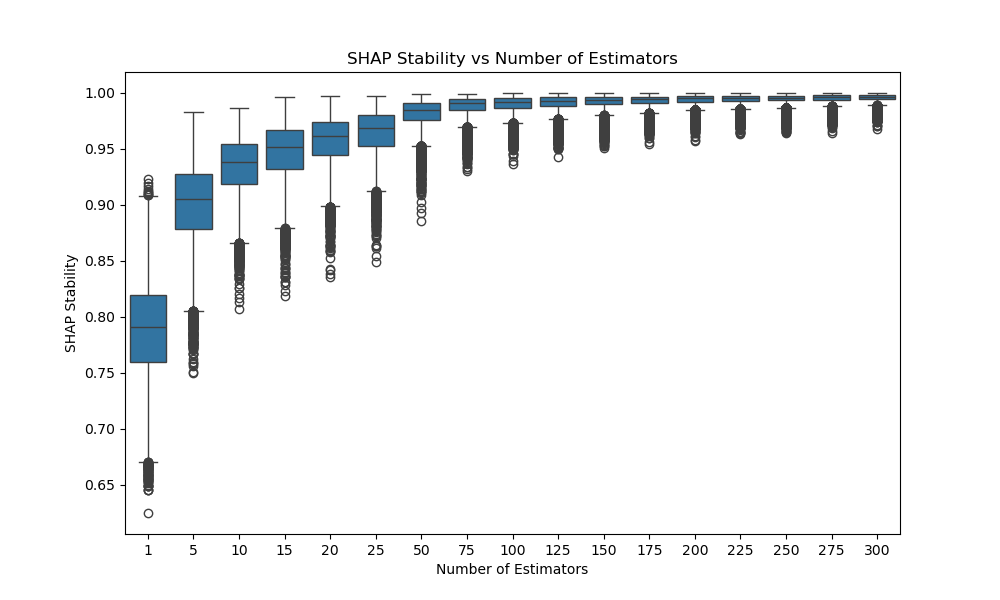

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data simulating the user's dataframe structure.
# For demonstration purposes, we use random data here.
# The user would replace this with their actual dataframe.

# Choosing the row with the highest max_feats and n_feats for each n_estimator
selected_rows = df.sort_values(by=['max_feats', 'n_feats'], ascending=[False, False]).drop_duplicates(['n_estimators'])

# Exploding the list in 'shap_stab' into separate rows.
df_exploded = selected_rows.explode('shap_stab')

# Convert 'shap_stab' to numeric as it might be read as object due to the list.
df_exploded['shap_stab'] = pd.to_numeric(df_exploded['shap_stab'])

# Creating a boxplot with 'n_estimators' on the x-axis and 'shap_stab' values on the y-axis.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exploded, x='n_estimators', y='shap_stab')

# Additional plot formatting, if necessary
plt.title('SHAP Stability vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('SHAP Stability')
plt.show()
